In [1]:
import monai

In [1]:
CONFIG_PATH = "./10441/copick.config"
RESOLUTION = 2
SESSION_ID = "0"
TOMO_TYPE = "wbp" 
USER_ID = "curation"
VOXEL_SIZE =  10
VOXEL_SPACING = VOXEL_SIZE *  (2**RESOLUTION)
config_blob = """{
    "name": "czii_cryoet_mlchallenge_2024",
    "description": "2024 CZII CryoET ML Challenge training data.",
    "version": "1.0.0",
    "pickable_objects": [
        {
            "name": "apo-ferritin",
            "identifier": "GO:0070288",
            "is_particle": true,
            "pdb_id": "4V1W",
            "label": 1,
            "color": [  0, 117, 220, 128],
            "radius": 60,
            "map_threshold": 0.0418
        },
        {
            "name": "beta-amylase",
            "identifier": "UniProtKB:P10537",
            "is_particle": true,
            "pdb_id": "1FA2",
            "label": 2,
            "color": [153,  63,   0, 128],
            "radius": 65,
            "map_threshold": 0.035
        },
        {
            "name": "beta-galactosidase",
            "identifier": "UniProtKB:P00722",
            "is_particle": true,
            "pdb_id": "6X1Q",
            "label": 3,
            "color": [ 76,   0,  92, 128],
            "radius": 90,
            "map_threshold": 0.0578
        },
        {
            "name": "ribosome",
            "identifier": "GO:0022626",
            "is_particle": true,
            "pdb_id": "6EK0",
            "label": 4,
            "color": [  0,  92,  49, 128],
            "radius": 150,
            "map_threshold": 0.0374
        },
        {
            "name": "thyroglobulin",
            "identifier": "UniProtKB:P01267",
            "is_particle": true,
            "pdb_id": "6SCJ",
            "label": 5,
            "color": [ 43, 206,  72, 128],
            "radius": 130,
            "map_threshold": 0.0278
        },
        {
            "name": "virus-like-particle",
            "identifier": "GO:0170047",
            "is_particle": true,
            "pdb_id": "6N4V",            
            "label": 6,
            "color": [255, 204, 153, 128],
            "radius": 135,
            "map_threshold": 0.201
        }
    ],
    "overlay_root": "./10441/overlay/",
    "static_root": "./10441/overlay/",
    "overlay_fs_args": {
        "auto_mkdir": true
    }
}"""
with open(CONFIG_PATH, "w") as f:
    f.write(config_blob)


In [2]:
import copick
import numpy as np
from tqdm import tqdm

root = copick.from_file(CONFIG_PATH)

copick_user_name = "copickUtils"
copick_segmentation_name = "paintedPicks"
voxel_size = VOXEL_SIZE

In [3]:
print(f"Number of runs: {len(root.runs)}")

Number of runs: 27


In [4]:
from copick_utils.segmentation import segmentation_from_picks
import copick_utils.writers.write as write
from collections import defaultdict

# Just do this once
generate_masks = True
if generate_masks:
    target_objects = defaultdict(dict)
    for object in root.pickable_objects:
        if object.is_particle:
            target_objects[object.name]['label'] = object.label
            target_objects[object.name]['radius'] = object.radius


    for run in tqdm(root.runs):
        tomo = run.get_voxel_spacing(voxel_size)
        tomo = tomo.get_tomogram(TOMO_TYPE).numpy()
        target = np.zeros(tomo.shape, dtype=np.uint8)
        for pickable_object in root.pickable_objects:
            pick = run.get_picks(object_name=pickable_object.name, user_id="curation")
            if len(pick):  
                target = segmentation_from_picks.from_picks(pick[0], 
                                                            target, 
                                                            target_objects[pickable_object.name]['radius'] * 0.8,
                                                            target_objects[pickable_object.name]['label']
                                                            )
        write.segmentation(run, target, copick_user_name, name=copick_segmentation_name)


  0%|          | 0/27 [00:00<?, ?it/s]


ReadOnlyError: object is read-only

In [5]:

from pathlib import Path
import numpy as np

tomo_type_list = ["wbp"]
# Define directories for saving numpy arrays
train_image_dir = Path('./datasets/train/images')
train_label_dir = Path('./datasets/train/labels')
val_image_dir = Path('./datasets/val/images')
val_label_dir = Path('./datasets/val/labels')

for dir_path in [train_image_dir, train_label_dir, val_image_dir, val_label_dir]:
    dir_path.mkdir(parents=True, exist_ok=True)

# root.runs의 개수 출력
print(f"Number of runs: {len(root.runs)}")

for tomo_type in tomo_type_list:
    print(f"Processing \"{tomo_type}\" data...")
    for vol_idx, run in enumerate(root.runs):
        # Load image and label data
        tomogram = run.get_voxel_spacing(voxel_size).get_tomogram(tomo_type).numpy()
        segmentation = run.get_segmentations(
            name=copick_segmentation_name,
            user_id=copick_user_name,
            voxel_size=voxel_size,
            is_multilabel=True
        )[0].numpy()

        # Format run name
        run_name = run.name.replace("\\", "_").replace("/", "_")

        # Determine if this is the last volume
        is_val_volume = True if vol_idx >= (len(root.runs) - 3) else False

        # Set directories based on whether it's the last volume
        image_dir = val_image_dir if is_val_volume else train_image_dir
        label_dir = val_label_dir if is_val_volume else train_label_dir

        # Save tomogram and segmentation as numpy arrays
        image_path = image_dir / f"{tomo_type}_{run_name}.npy"
        label_path = label_dir / f"{tomo_type}_{run_name}.npy"
        np.save(image_path, tomogram)
        np.save(label_path, segmentation)

        # 저장된 파일 경로 출력
        print(f"Saved image: {image_path}")
        print(f"Saved label: {label_path}")

# 저장된 파일의 개수 출력
print(f"Number of files in train images: {len(list(train_image_dir.glob('*.npy')))}")
print(f"Number of files in train labels: {len(list(train_label_dir.glob('*.npy')))}")
print(f"Number of files in val images: {len(list(val_image_dir.glob('*.npy')))}")
print(f"Number of files in val labels: {len(list(val_label_dir.glob('*.npy')))}")

print("Processing complete.")

Number of runs: 27
Processing "wbp" data...
Saved image: datasets\train\images\wbp_TS_0.npy
Saved label: datasets\train\labels\wbp_TS_0.npy
Saved image: datasets\train\images\wbp_TS_1.npy
Saved label: datasets\train\labels\wbp_TS_1.npy
Saved image: datasets\train\images\wbp_TS_10.npy
Saved label: datasets\train\labels\wbp_TS_10.npy
Saved image: datasets\train\images\wbp_TS_11.npy
Saved label: datasets\train\labels\wbp_TS_11.npy
Saved image: datasets\train\images\wbp_TS_12.npy
Saved label: datasets\train\labels\wbp_TS_12.npy
Saved image: datasets\train\images\wbp_TS_13.npy
Saved label: datasets\train\labels\wbp_TS_13.npy
Saved image: datasets\train\images\wbp_TS_14.npy
Saved label: datasets\train\labels\wbp_TS_14.npy
Saved image: datasets\train\images\wbp_TS_15.npy
Saved label: datasets\train\labels\wbp_TS_15.npy
Saved image: datasets\train\images\wbp_TS_16.npy
Saved label: datasets\train\labels\wbp_TS_16.npy
Saved image: datasets\train\images\wbp_TS_17.npy
Saved label: datasets\train\l

label unique values: [0 1 2 3 4 5 6]


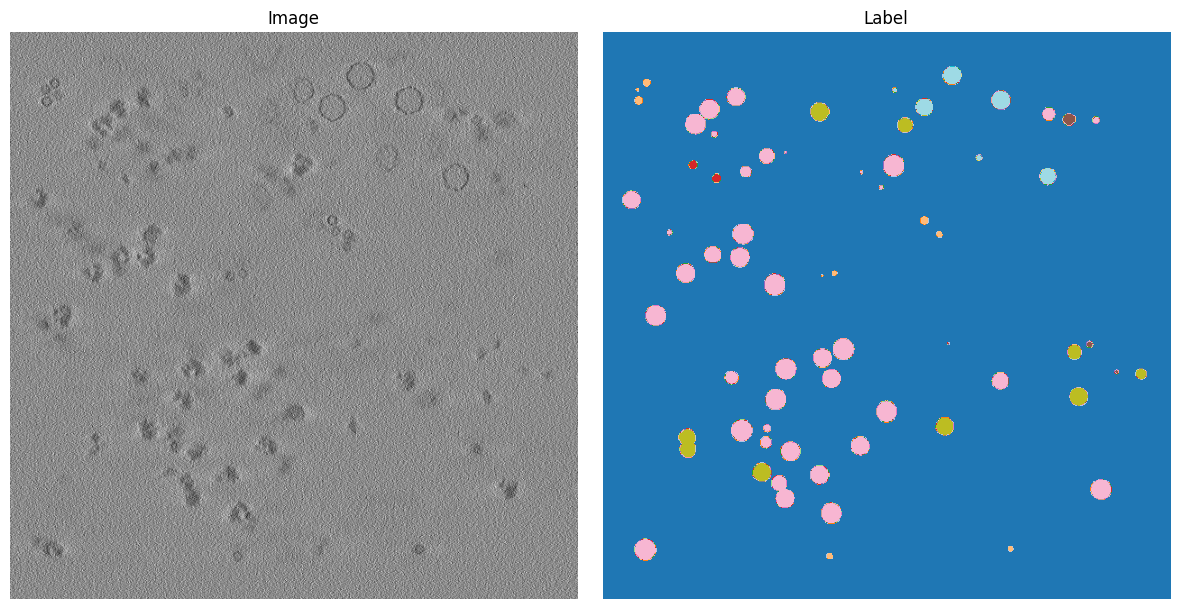

In [123]:
import numpy as np
import matplotlib.pyplot as plt

# Load the first image and label
image = np.load("datasets/train/images/wbp_TS_14_image.npy")
label = np.load("datasets/train/labels/wbp_TS_14_label.npy")
print("label unique values:", np.unique(label))
# Display the image and label
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image[100], cmap="gray")
plt.title("Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(label[100], cmap="tab20")
plt.title("Label")
plt.axis("off")

plt.tight_layout()
plt.show()


In [3]:
# Make a copick project
import os
import shutil

config_blob = """{
    "name": "czii_cryoet_mlchallenge_2024",
    "description": "2024 CZII CryoET ML Challenge training data.",
    "version": "1.0.0",

    "pickable_objects": [
        {
            "name": "apo-ferritin",
            "is_particle": true,
            "pdb_id": "4V1W",
            "label": 1,
            "color": [  0, 117, 220, 128],
            "radius": 60,
            "map_threshold": 0.0418
        },
        {
          "name" : "beta-amylase",
            "is_particle": true,
            "pdb_id": "8ZRZ",
            "label": 2,
            "color": [255, 255, 255, 128],
            "radius": 90,
            "map_threshold": 0.0578  
        },
        {
            "name": "beta-galactosidase",
            "is_particle": true,
            "pdb_id": "6X1Q",
            "label": 3,
            "color": [ 76,   0,  92, 128],
            "radius": 90,
            "map_threshold": 0.0578
        },
        {
            "name": "ribosome",
            "is_particle": true,
            "pdb_id": "6EK0",
            "label": 4,
            "color": [  0,  92,  49, 128],
            "radius": 150,
            "map_threshold": 0.0374
        },
        {
            "name": "thyroglobulin",
            "is_particle": true,
            "pdb_id": "6SCJ",
            "label": 5,
            "color": [ 43, 206,  72, 128],
            "radius": 130,
            "map_threshold": 0.0278
        },
        {
            "name": "virus-like-particle",
            "is_particle": true,
            "label": 6,
            "color": [255, 204, 153, 128],
            "radius": 135,
            "map_threshold": 0.201
        },
        {
            "name": "membrane",
            "is_particle": false,
            "label": 8,
            "color": [100, 100, 100, 128]
        },
        {
            "name": "background",
            "is_particle": false,
            "label": 9,
            "color": [10, 150, 200, 128]
        }
    ],

    "overlay_root": "./kaggle/working/overlay",

    "overlay_fs_args": {
        "auto_mkdir": true
    },

    "static_root": "./kaggle/input/czii-cryo-et-object-identification/train/static"
}"""

copick_config_path = "./kaggle/working/copick.config"
output_overlay = "./kaggle/working/overlay"


with open(copick_config_path, "w") as f:
    f.write(config_blob)
    
# Update the overlay
# Define source and destination directories
source_dir = './kaggle/input/czii-cryo-et-object-identification/train/overlay'
destination_dir = './kaggle/working/overlay'

# Walk through the source directory
for root, dirs, files in os.walk(source_dir):
    # Create corresponding subdirectories in the destination
    relative_path = os.path.relpath(root, source_dir)
    target_dir = os.path.join(destination_dir, relative_path)
    os.makedirs(target_dir, exist_ok=True)
    
    # Copy and rename each file
    for file in files:
        if file.startswith("curation_0_"):
            new_filename = file
        else:
            new_filename = f"curation_0_{file}"
            
        
        # Define full paths for the source and destination files
        source_file = os.path.join(root, file)
        destination_file = os.path.join(target_dir, new_filename)
        
        # Copy the file with the new name
        shutil.copy2(source_file, destination_file)
        print(f"Copied {source_file} to {destination_file}")

Copied ./kaggle/input/czii-cryo-et-object-identification/train/overlay\ExperimentRuns\TS_5_4\Picks\apo-ferritin.json to ./kaggle/working/overlay\ExperimentRuns\TS_5_4\Picks\curation_0_apo-ferritin.json
Copied ./kaggle/input/czii-cryo-et-object-identification/train/overlay\ExperimentRuns\TS_5_4\Picks\beta-amylase.json to ./kaggle/working/overlay\ExperimentRuns\TS_5_4\Picks\curation_0_beta-amylase.json
Copied ./kaggle/input/czii-cryo-et-object-identification/train/overlay\ExperimentRuns\TS_5_4\Picks\beta-galactosidase.json to ./kaggle/working/overlay\ExperimentRuns\TS_5_4\Picks\curation_0_beta-galactosidase.json
Copied ./kaggle/input/czii-cryo-et-object-identification/train/overlay\ExperimentRuns\TS_5_4\Picks\ribosome.json to ./kaggle/working/overlay\ExperimentRuns\TS_5_4\Picks\curation_0_ribosome.json
Copied ./kaggle/input/czii-cryo-et-object-identification/train/overlay\ExperimentRuns\TS_5_4\Picks\thyroglobulin.json to ./kaggle/working/overlay\ExperimentRuns\TS_5_4\Picks\curation_0_thy

In [4]:
import copick
import numpy as np
from tqdm import tqdm

root = copick.from_file(copick_config_path)

copick_user_name = "copickUtils"
copick_segmentation_name = "paintedPicks"
voxel_size = 10

In [5]:
len(root.runs)

7

In [6]:
from copick_utils.segmentation import segmentation_from_picks
import copick_utils.writers.write as write
from collections import defaultdict

# Just do this once
generate_masks = True
# tomo_type_list = ["ctfdeconvolved", "denoised", "isonetcorrected", "wbp"]
tomo_type_list = ["wbp"]
for tomo_type in tomo_type_list:

    if generate_masks:
        target_objects = defaultdict(dict)
        for object in root.pickable_objects:
            if object.is_particle:
                target_objects[object.name]['label'] = object.label
                target_objects[object.name]['radius'] = object.radius


        for run in tqdm(root.runs):
            tomo = run.get_voxel_spacing(10)
            tomo = tomo.get_tomogram(tomo_type).numpy()
            target = np.zeros(tomo.shape, dtype=np.uint8)
            for pickable_object in root.pickable_objects:
                pick = run.get_picks(object_name=pickable_object.name, user_id="curation")
                if len(pick):  
                    target = segmentation_from_picks.from_picks(pick[0], 
                                                                target, 
                                                                target_objects[pickable_object.name]['radius'] * 0.8,
                                                                target_objects[pickable_object.name]['label']
                                                                )
            write.segmentation(run, target, copick_user_name, name=copick_segmentation_name)

100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


In [7]:
from pathlib import Path
import numpy as np

tomo_type_list = ["wbp"]
# Define directories for saving numpy arrays
train_image_dir = Path('./datasets/train/images')
train_label_dir = Path('./datasets/train/labels')
val_image_dir = Path('./datasets/val/images')
val_label_dir = Path('./datasets/val/labels')

for dir_path in [train_image_dir, train_label_dir, val_image_dir, val_label_dir]:
    dir_path.mkdir(parents=True, exist_ok=True)

# root.runs의 개수 출력
print(f"Number of runs: {len(root.runs)}")

for tomo_type in tomo_type_list:
    print(f"Processing \"{tomo_type}\" data...")
    for vol_idx, run in enumerate(root.runs):
        # Load image and label data
        tomogram = run.get_voxel_spacing(voxel_size).get_tomogram(tomo_type).numpy()
        segmentation = run.get_segmentations(
            name=copick_segmentation_name,
            user_id=copick_user_name,
            voxel_size=voxel_size,
            is_multilabel=True
        )[0].numpy()

        # Format run name
        run_name = run.name.replace("\\", "_").replace("/", "_")

        # Determine if this is the last volume
        is_last_volume = (vol_idx == len(root.runs) - 1)

        # Set directories based on whether it's the last volume
        image_dir = val_image_dir if is_last_volume else train_image_dir
        label_dir = val_label_dir if is_last_volume else train_label_dir

        # Save tomogram and segmentation as numpy arrays
        image_path = image_dir / f"{tomo_type}_{run_name}.npy"
        label_path = label_dir / f"{tomo_type}_{run_name}.npy"
        np.save(image_path, tomogram)
        np.save(label_path, segmentation)

        # 저장된 파일 경로 출력
        print(f"Saved image: {image_path}")
        print(f"Saved label: {label_path}")

# 저장된 파일의 개수 출력
print(f"Number of files in train images: {len(list(train_image_dir.glob('*.npy')))}")
print(f"Number of files in train labels: {len(list(train_label_dir.glob('*.npy')))}")
print(f"Number of files in val images: {len(list(val_image_dir.glob('*.npy')))}")
print(f"Number of files in val labels: {len(list(val_label_dir.glob('*.npy')))}")

print("Processing complete.")

Number of runs: 7
Processing "wbp" data...
Saved image: datasets\train\images\wbp_TS_5_4.npy
Saved label: datasets\train\labels\wbp_TS_5_4.npy
Saved image: datasets\train\images\wbp_TS_69_2.npy
Saved label: datasets\train\labels\wbp_TS_69_2.npy
Saved image: datasets\train\images\wbp_TS_6_4.npy
Saved label: datasets\train\labels\wbp_TS_6_4.npy
Saved image: datasets\train\images\wbp_TS_6_6.npy
Saved label: datasets\train\labels\wbp_TS_6_6.npy
Saved image: datasets\train\images\wbp_TS_73_6.npy
Saved label: datasets\train\labels\wbp_TS_73_6.npy
Saved image: datasets\train\images\wbp_TS_86_3.npy
Saved label: datasets\train\labels\wbp_TS_86_3.npy
Saved image: datasets\val\images\wbp_TS_99_9.npy
Saved label: datasets\val\labels\wbp_TS_99_9.npy
Number of files in train images: 30
Number of files in train labels: 30
Number of files in val images: 4
Number of files in val labels: 4
Processing complete.


## 10441 추가 데이터셋 처리

In [ ]:
# Make a copick project
import os
import shutil
import monai

config_blob = """{
    "name": "czii_cryoet_mlchallenge_2024",
    "description": "2024 CZII CryoET ML Challenge training data.",
    "version": "1.0.0",

    "pickable_objects": [
        {
            "name": "apo-ferritin",
            "is_particle": true,
            "pdb_id": "4V1W",
            "label": 1,
            "color": [  0, 117, 220, 128],
            "radius": 60,
            "map_threshold": 0.0418
        },
        {
          "name" : "beta-amylase",
            "is_particle": true,
            "pdb_id": "8ZRZ",
            "label": 2,
            "color": [255, 255, 255, 128],
            "radius": 90,
            "map_threshold": 0.0578  
        },
        {
            "name": "beta-galactosidase",
            "is_particle": true,
            "pdb_id": "6X1Q",
            "label": 3,
            "color": [ 76,   0,  92, 128],
            "radius": 90,
            "map_threshold": 0.0578
        },
        {
            "name": "ribosome",
            "is_particle": true,
            "pdb_id": "6EK0",
            "label": 4,
            "color": [  0,  92,  49, 128],
            "radius": 150,
            "map_threshold": 0.0374
        },
        {
            "name": "thyroglobulin",
            "is_particle": true,
            "pdb_id": "6SCJ",
            "label": 5,
            "color": [ 43, 206,  72, 128],
            "radius": 130,
            "map_threshold": 0.0278
        },
        {
            "name": "virus-like-particle",
            "is_particle": true,
            "label": 6,
            "color": [255, 204, 153, 128],
            "radius": 135,
            "map_threshold": 0.201
        },
        {
            "name": "membrane",
            "is_particle": false,
            "label": 8,
            "color": [100, 100, 100, 128]
        },
        {
            "name": "background",
            "is_particle": false,
            "label": 9,
            "color": [10, 150, 200, 128]
        }
    ],

    "overlay_root": "./kaggle/working/overlay",

    "overlay_fs_args": {
        "auto_mkdir": true
    },

    "static_root": "./kaggle/input/czii-cryo-et-object-identification/train/static"
}"""

copick_config_path = "./kaggle/working/copick.config"
output_overlay = "./kaggle/working/overlay"


with open(copick_config_path, "w") as f:
    f.write(config_blob)
    
# Update the overlay
# Define source and destination directories
source_dir = './kaggle/input/czii-cryo-et-object-identification/train/overlay'
destination_dir = './kaggle/working/overlay'

# Walk through the source directory
for root, dirs, files in os.walk(source_dir):
    # Create corresponding subdirectories in the destination
    relative_path = os.path.relpath(root, source_dir)
    target_dir = os.path.join(destination_dir, relative_path)
    os.makedirs(target_dir, exist_ok=True)
    
    # Copy and rename each file
    for file in files:
        if file.startswith("curation_0_"):
            new_filename = file
        else:
            new_filename = f"curation_0_{file}"
            
        
        # Define full paths for the source and destination files
        source_file = os.path.join(root, file)
        destination_file = os.path.join(target_dir, new_filename)
        
        # Copy the file with the new name
        shutil.copy2(source_file, destination_file)
        print(f"Copied {source_file} to {destination_file}")

## Test Set 시각화 코드

In [12]:
# Make a copick project
import os
import shutil
from pathlib import Path

config_blob = """{
    "name": "czii_cryoet_mlchallenge_2024",
    "description": "2024 CZII CryoET ML Challenge training data.",
    "version": "1.0.0",

    "pickable_objects": [
        {
            "name": "apo-ferritin",
            "is_particle": true,
            "pdb_id": "4V1W",
            "label": 1,
            "color": [  0, 117, 220, 128],
            "radius": 60,
            "map_threshold": 0.0418
        },
        {
          "name" : "beta-amylase",
            "is_particle": true,
            "pdb_id": "8ZRZ",
            "label": 2,
            "color": [255, 255, 255, 128],
            "radius": 90,
            "map_threshold": 0.0578  
        },
        {
            "name": "beta-galactosidase",
            "is_particle": true,
            "pdb_id": "6X1Q",
            "label": 3,
            "color": [ 76,   0,  92, 128],
            "radius": 90,
            "map_threshold": 0.0578
        },
        {
            "name": "ribosome",
            "is_particle": true,
            "pdb_id": "6EK0",
            "label": 4,
            "color": [  0,  92,  49, 128],
            "radius": 150,
            "map_threshold": 0.0374
        },
        {
            "name": "thyroglobulin",
            "is_particle": true,
            "pdb_id": "6SCJ",
            "label": 5,
            "color": [ 43, 206,  72, 128],
            "radius": 130,
            "map_threshold": 0.0278
        },
        {
            "name": "virus-like-particle",
            "is_particle": true,
            "label": 6,
            "color": [255, 204, 153, 128],
            "radius": 135,
            "map_threshold": 0.201
        },
        {
            "name": "membrane",
            "is_particle": false,
            "label": 8,
            "color": [100, 100, 100, 128]
        },
        {
            "name": "background",
            "is_particle": false,
            "label": 9,
            "color": [10, 150, 200, 128]
        }
    ],

    "overlay_root": "./kaggle/working/overlay",

    "overlay_fs_args": {
        "auto_mkdir": true
    },

    "static_root": "./kaggle/input/czii-cryo-et-object-identification/test/static"
}"""

copick_config_path = "./kaggle/working/copick.config"
output_overlay = "./kaggle/working/overlay"


with open(copick_config_path, "w") as f:
    f.write(config_blob)
    
import copick
import numpy as np
from tqdm import tqdm

root = copick.from_file(copick_config_path)
print(len(root.runs))

run = root.runs[0]
print(run.name)
tomo = run.get_voxel_spacing(10).get_tomogram("denoised").numpy()
tomo.shape

7
TS_5_4


(184, 630, 630)

In [13]:

copick_user_name = "copickUtils"
copick_segmentation_name = "paintedPicks"
voxel_size = 10
tomo_type_list = ["denoised"]
task_dir = Path('./datasets/task/images')
for dir_path in [task_dir]:
    dir_path.mkdir(parents=True, exist_ok=True)

for tomo_type in tomo_type_list:
    print(f"Processing \"{tomo_type}\" data...")
    for run in root.runs:
        # Load image and label data
        tomogram = run.get_voxel_spacing(voxel_size).get_tomogram(tomo_type).numpy()

        # Format run name
        run_name = run.name.replace("\\", "_").replace("/", "_")

        # Save tomogram as numpy array
        image_path = task_dir / f"{tomo_type}_{run_name}_image.npy"
        np.save(image_path, tomogram)

        # 저장된 파일 경로 출력
        print(f"Saved image: {image_path}")
print("Processing complete.")


Processing "denoised" data...
Saved image: datasets\task\images\denoised_TS_5_4_image.npy
Saved image: datasets\task\images\denoised_TS_69_2_image.npy
Saved image: datasets\task\images\denoised_TS_6_4_image.npy


AttributeError: 'NoneType' object has no attribute 'get_tomogram'